In [123]:
# This notebook will be for Classification testing (Supervised Learning)
# Decision Tree, SGD Classifier/SVM - Logistic Regression
# Importing Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [124]:
# # importing dataset
# old way
from dotenv import load_dotenv

load_dotenv()

dataset_path = os.getenv('CLEANED_DATA_PATH')

df_cleaned = pd.read_csv(dataset_path)

In [125]:
# importing dataset
# df_cleaned = pd.read_parquet('data/application_cleaned.parquet', engine = 'pyarrow')

^ for some reason the OCCUPATION_TYPE column was behaving weirdly when I used this, maybe I did not run all the cells in the main notebook before exporting but idk

In [126]:
df_cleaned.shape

(305181, 39)

In [ ]:
# goodbye new mothers
df_cleaned = df_cleaned[df_cleaned['NAME_INCOME_TYPE'] != 'Maternity leave']

In [150]:
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
# categorical_cols

In [151]:
numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('TARGET')
# numerical_cols

In [152]:
# viewing the number of null values in each column
null_counts = df_cleaned.isnull().sum()
print(null_counts)

TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        0
NAME_TYPE_SUITE                    0
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OCCUPATION_TYPE                40665
CNT_FAM_MEMBERS                    0
REGION_RATING_CLIENT_W_CITY        0
WEEKDAY_APPR_PROCESS_START         0
HOUR_APPR_PROCESS_START            0
REG_REGION_NOT_LIVE_REGION         0
REG_REGION_NOT_WORK_REGION         0
LIVE_REGION_NOT_WORK_REGION        0
REG_CITY_NOT_LIVE_CITY             0
L

In [153]:
# Separate features and target
X = df_cleaned.drop('TARGET', axis=1)
if 'SK_ID_CURR' in X.columns:
    X = X.drop('SK_ID_CURR', axis=1)  # Remove ID column if present
y = df_cleaned['TARGET']

In [154]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [155]:
# Feature scaling
print('Applying feature scaling...')
# Scale numerical features
scaler = RobustScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
print(f'Scaled {len(numerical_cols)} numerical columns')

Applying feature scaling...
Scaled 26 numerical columns


In [156]:
# Impute missing values for numerical columns with median

missing_num_col = ['AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

missing_cat_col = ['OCCUPATION_TYPE']

num_imp = ColumnTransformer(transformers=
                            [('numimp', SimpleImputer(strategy='mean', add_indicator=True), missing_num_col),
                            ('catimp', SimpleImputer(strategy='most_frequent', add_indicator=True), missing_cat_col)], 
                         remainder="passthrough").set_output(transform='pandas')
# num_imputer = SimpleImputer(strategy='mean', add_indicator=True)
X_train = num_imp.fit_transform(X_train)

# df_num_imputed = pd.DataFrame(num_imputed_array, columns=numerical_cols)


In [157]:
# Verify no missing values remain
missing_after = X_train.isnull().sum().sum()
print(f'Missing values after imputation: {missing_after}')

Missing values after imputation: 0


In [158]:
categorical_cols_imp = X_train.select_dtypes(include=['object']).columns.tolist()

categorical_cols_imp.remove('catimp__missingindicator_OCCUPATION_TYPE')

categorical_cols_imp

['catimp__OCCUPATION_TYPE',
 'remainder__NAME_CONTRACT_TYPE',
 'remainder__CODE_GENDER',
 'remainder__FLAG_OWN_CAR',
 'remainder__FLAG_OWN_REALTY',
 'remainder__NAME_TYPE_SUITE',
 'remainder__NAME_INCOME_TYPE',
 'remainder__NAME_EDUCATION_TYPE',
 'remainder__NAME_FAMILY_STATUS',
 'remainder__NAME_HOUSING_TYPE',
 'remainder__WEEKDAY_APPR_PROCESS_START',
 'remainder__ORGANIZATION_TYPE']

In [159]:
# one hot encoding categorical variables for training set

ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse_output=False), categorical_cols_imp)], 
                       remainder="passthrough").set_output(transform='pandas')
X_train = ct.fit_transform(X_train)

# OneHotEncoder = OneHotEncoder()
# OneHotEncoder.fit(X_train)
# X_train = OneHotEncoder.transform(X_train)

# ^This will include nulls. We will impute them. we can one hot encode all the categorical variables then use Bayesian ridge estimator. XGBoost is also viable, also requires one hot encoding, 
# however can overfit.

In [160]:
X_train

,ohe__catimp__OCCUPATION_TYPE_Accountants,ohe__catimp__OCCUPATION_TYPE_Cleaning staff,ohe__catimp__OCCUPATION_TYPE_Cooking staff,ohe__catimp__OCCUPATION_TYPE_Core staff,ohe__catimp__OCCUPATION_TYPE_Drivers,ohe__catimp__OCCUPATION_TYPE_HR staff,ohe__catimp__OCCUPATION_TYPE_High skill tech staff,ohe__catimp__OCCUPATION_TYPE_IT staff,ohe__catimp__OCCUPATION_TYPE_Laborers,ohe__catimp__OCCUPATION_TYPE_Low-skill Laborers,...,remainder__remainder__HOUR_APPR_PROCESS_START,remainder__remainder__REG_REGION_NOT_LIVE_REGION,remainder__remainder__REG_REGION_NOT_WORK_REGION,remainder__remainder__LIVE_REGION_NOT_WORK_REGION,remainder__remainder__REG_CITY_NOT_LIVE_CITY,remainder__remainder__LIVE_CITY_NOT_WORK_CITY,remainder__remainder__OBS_60_CNT_SOCIAL_CIRCLE,remainder__remainder__DEF_60_CNT_SOCIAL_CIRCLE,remainder__remainder__DAYS_LAST_PHONE_CHANGE,remainder__remainder__FLAG_DOCUMENT_3
166710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.25,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.010836,0.0
46927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.237616,0.0
142834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.75,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.184985,0.0
23372,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.110681,0.0
142536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.25,0.0,0.0,0.0,0.0,0.0,0.5,0.0,-0.179567,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.514706,0.0
270541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.191950,-1.0
87690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010062,0.0
287001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.630805,0.0


In [161]:
# Applying same methods to X_test data

# Feature scaling
print('Applying feature scaling...')
# Scale numerical features
scaler = RobustScaler()
X_test[numerical_cols] = scaler.fit_transform(X_test[numerical_cols])
print(f'Scaled {len(numerical_cols)} numerical columns')

missing_num_col = ['AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

missing_cat_col = ['OCCUPATION_TYPE']

num_imp = ColumnTransformer(transformers=
                            [('numimp', SimpleImputer(strategy='mean', add_indicator=True), missing_num_col),
                            ('catimp', SimpleImputer(strategy='most_frequent', add_indicator=True), missing_cat_col)], 
                         remainder="passthrough").set_output(transform='pandas')
# num_imputer = SimpleImputer(strategy='mean', add_indicator=True)
X_test = num_imp.fit_transform(X_test)

# Verify no missing values remain
missing_after = X_test.isnull().sum().sum()
print(f'Missing values after imputation: {missing_after}')

categorical_cols_imp = X_test.select_dtypes(include=['object']).columns.tolist()

categorical_cols_imp.remove('catimp__missingindicator_OCCUPATION_TYPE')

print(categorical_cols_imp)

ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse_output=False), categorical_cols_imp)], 
                       remainder="passthrough").set_output(transform='pandas')
X_test = ct.fit_transform(X_test)

Applying feature scaling...
Scaled 26 numerical columns
Missing values after imputation: 0
['catimp__OCCUPATION_TYPE', 'remainder__NAME_CONTRACT_TYPE', 'remainder__CODE_GENDER', 'remainder__FLAG_OWN_CAR', 'remainder__FLAG_OWN_REALTY', 'remainder__NAME_TYPE_SUITE', 'remainder__NAME_INCOME_TYPE', 'remainder__NAME_EDUCATION_TYPE', 'remainder__NAME_FAMILY_STATUS', 'remainder__NAME_HOUSING_TYPE', 'remainder__WEEKDAY_APPR_PROCESS_START', 'remainder__ORGANIZATION_TYPE']


In [162]:
train_col_list = X_train.columns.to_list()

test_col_list = X_test.columns.to_list()

diff = [item for item in train_col_list if item not in test_col_list]
diff


[]

In [169]:
X_train['remainder__catimp__missingindicator_OCCUPATION_TYPE'] = X_train['remainder__catimp__missingindicator_OCCUPATION_TYPE'].astype(bool)
X_test['remainder__catimp__missingindicator_OCCUPATION_TYPE'] = X_test['remainder__catimp__missingindicator_OCCUPATION_TYPE'].astype(bool)

Accuracy: 0.626925093387509


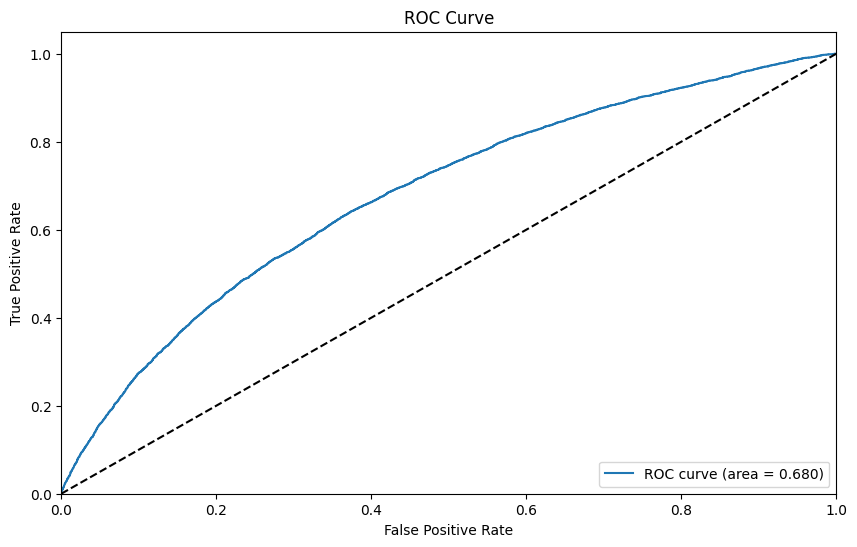

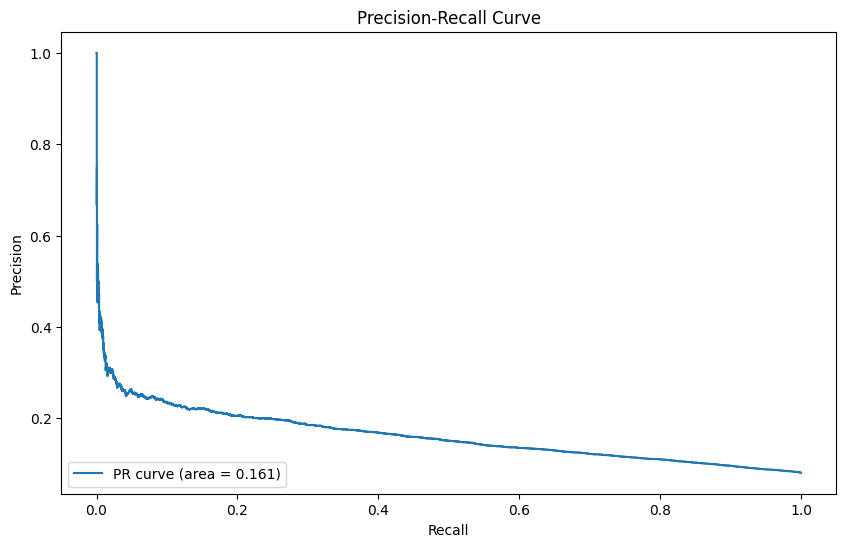

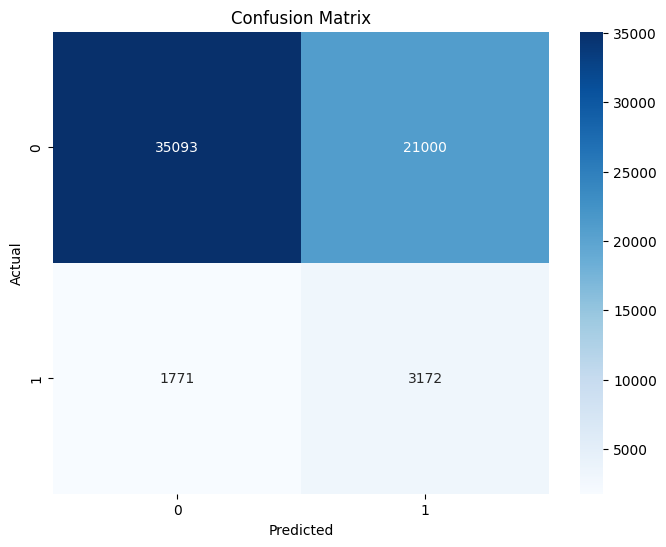

In [170]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, precision_score, recall_score, f1_score

# Create a logistic regression model
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Make predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Calculate metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Create classification report
report = classification_report(y_test, y_pred)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve')
plt.legend(loc="lower right");
# plt.savefig(f'ml_results/{model_name}_roc_curve.png')


# Plot Precision-Recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)
plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, label=f'PR curve (area = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve')
plt.legend(loc="lower left");
# plt.savefig(f'ml_results/{model_name}_pr_curve.png')


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix');
# plt.savefig(f'ml_results/{model_name}_confusion_matrix.png')


## AI strategy


Defining models to evaluate...

Evaluating models...
Evaluating Logistic Regression...
  ROC AUC: 0.6795
  Precision: 0.1312
  Recall: 0.6417
  F1 Score: 0.2179
  Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.63      0.76     56093
           1       0.13      0.64      0.22      4943

    accuracy                           0.63     61036
   macro avg       0.54      0.63      0.49     61036
weighted avg       0.89      0.63      0.71     61036


Evaluating Decision Tree...
  ROC AUC: 0.5175
  Precision: 0.1091
  Recall: 0.1246
  F1 Score: 0.1163
  Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     56093
           1       0.11      0.12      0.12      4943

    accuracy                           0.85     61036
   macro avg       0.52      0.52      0.52     61036
weighted avg       0.86      0.85      0.85     61036


Evaluating Random Forest...
  

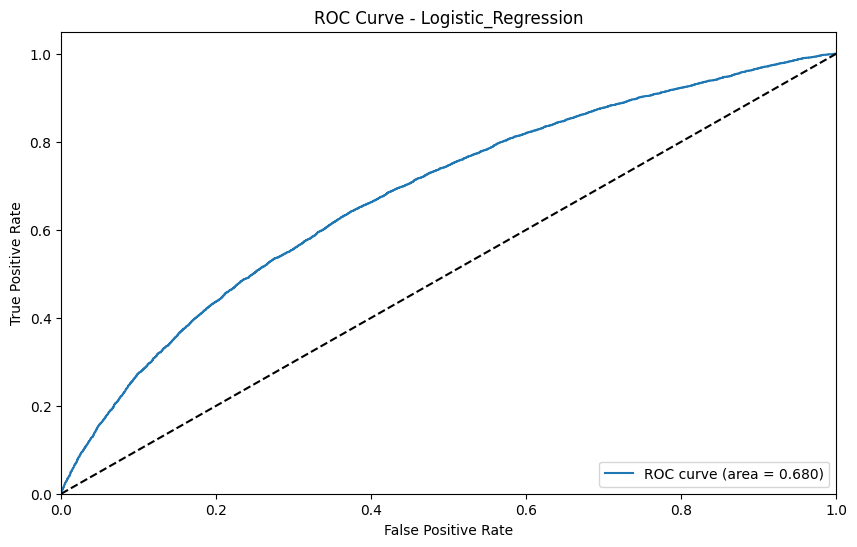

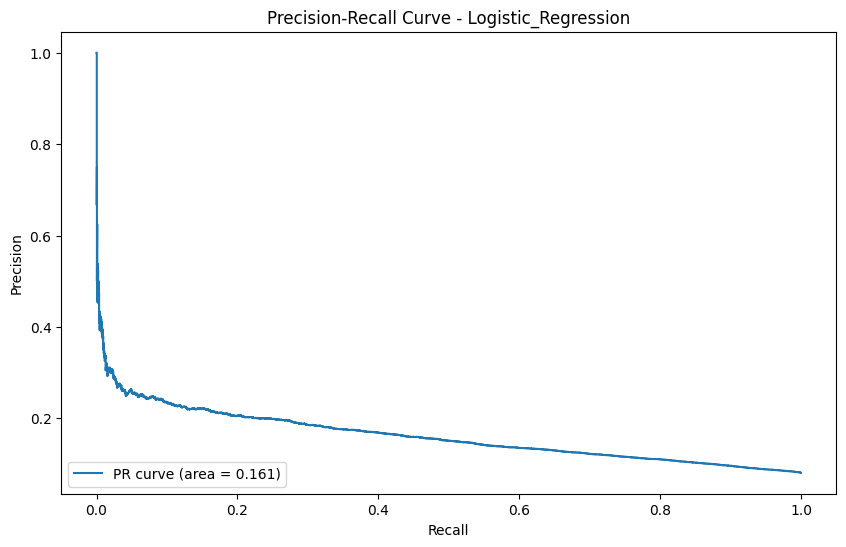

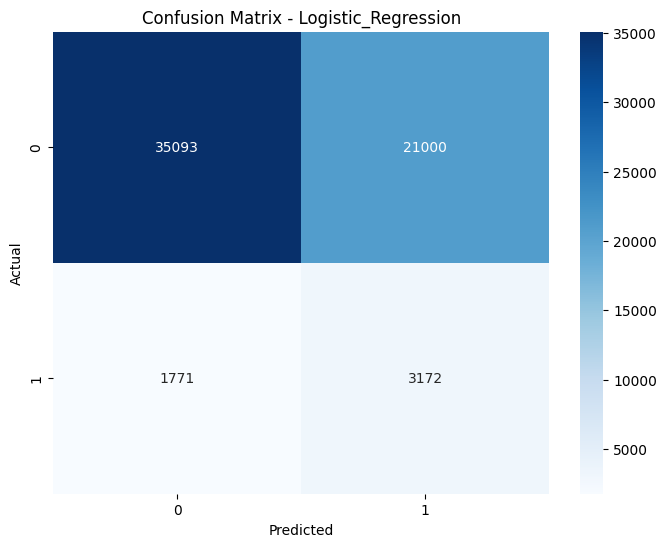

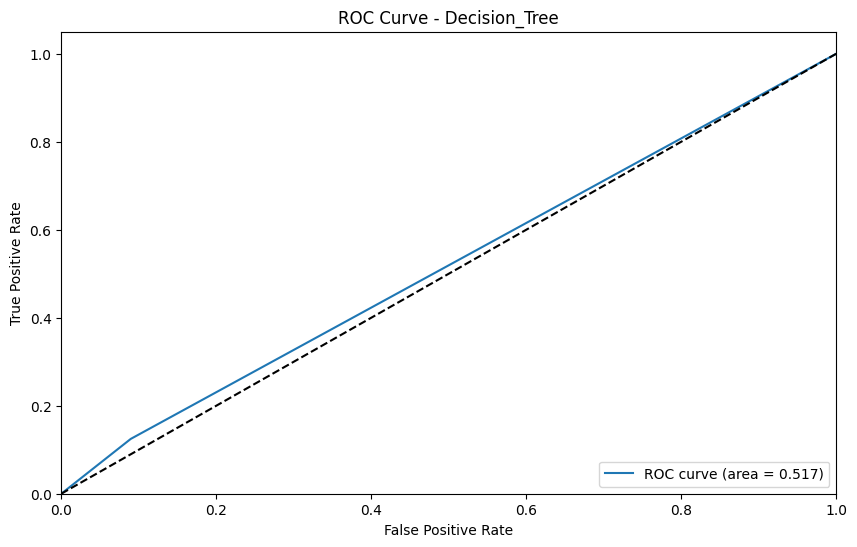

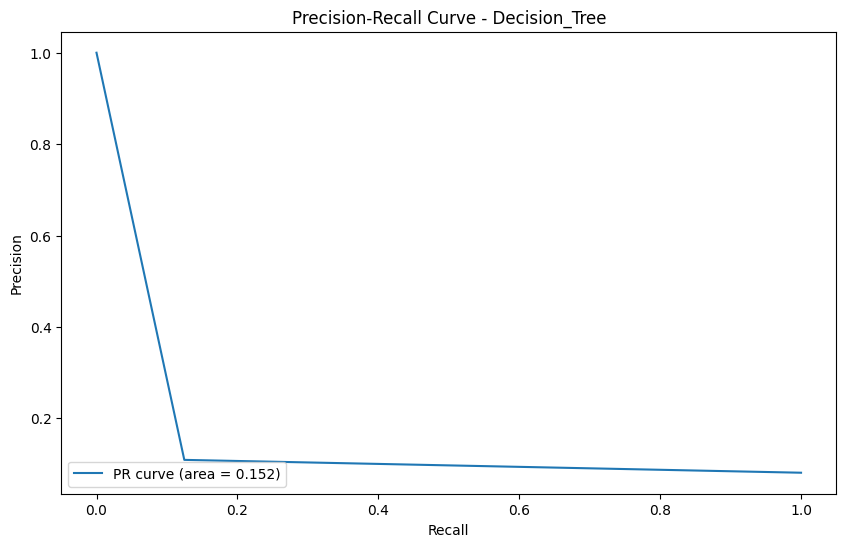

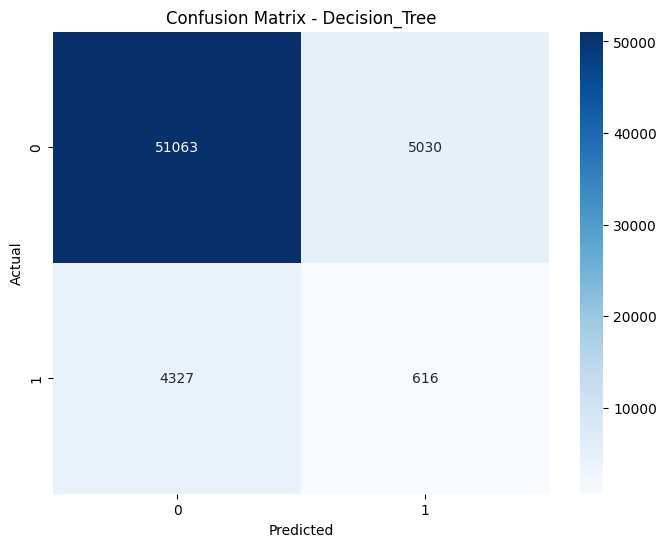

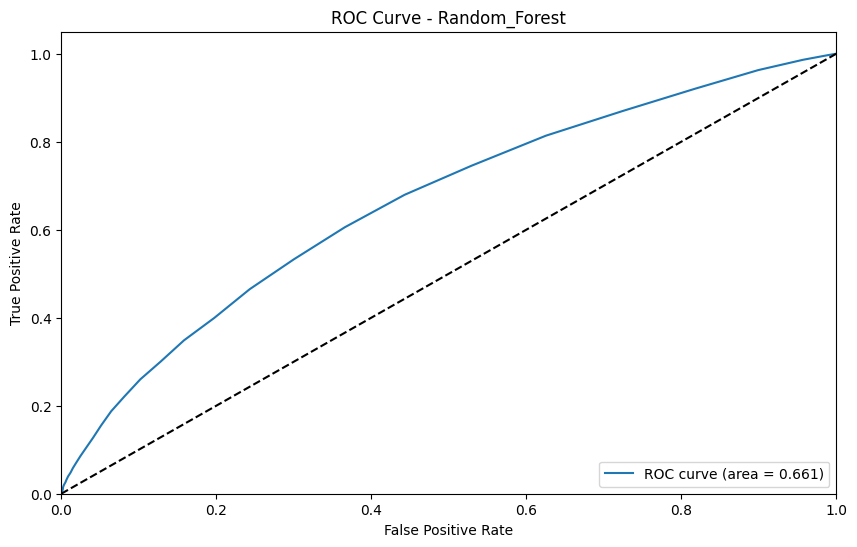

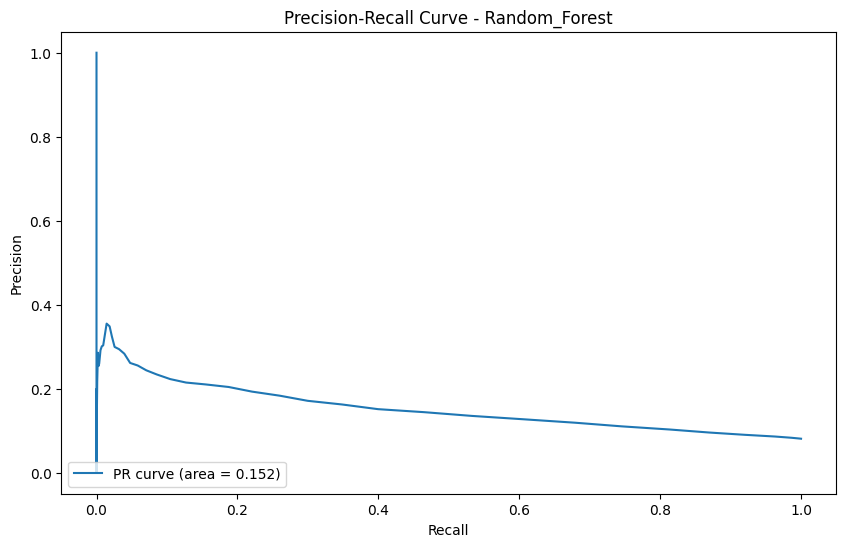

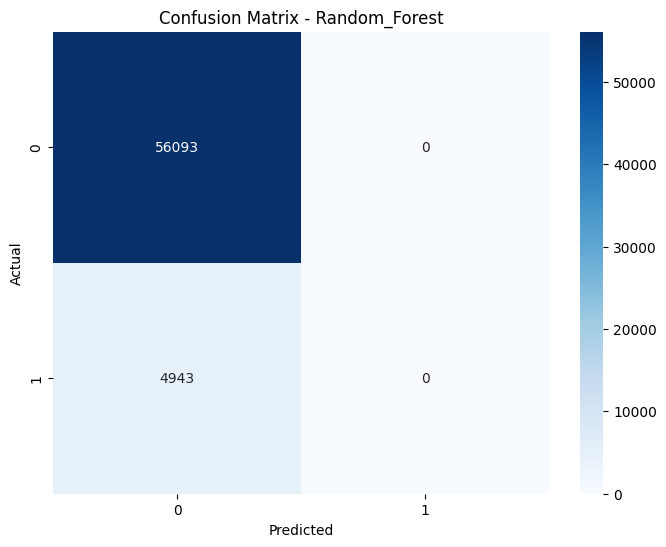

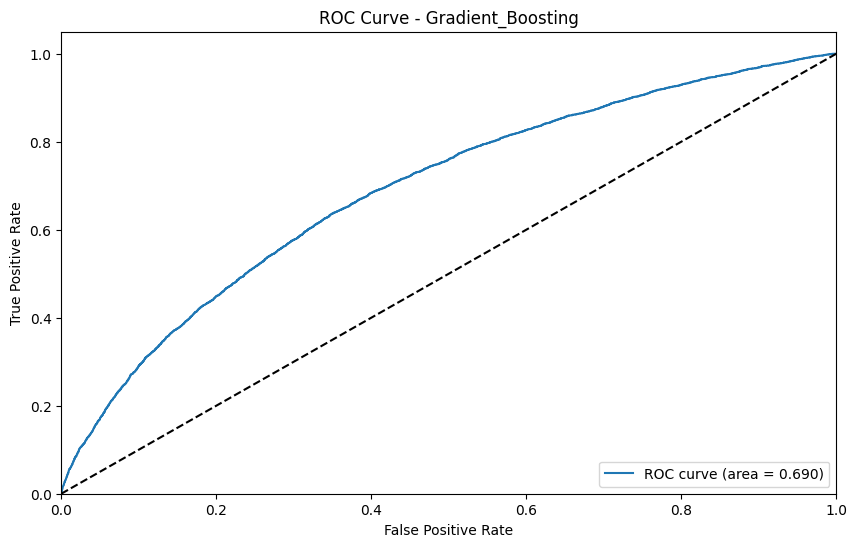

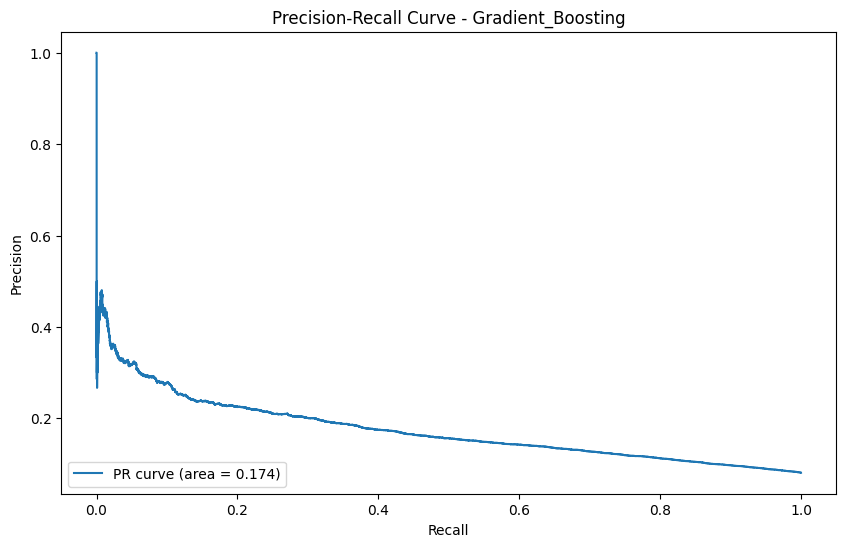

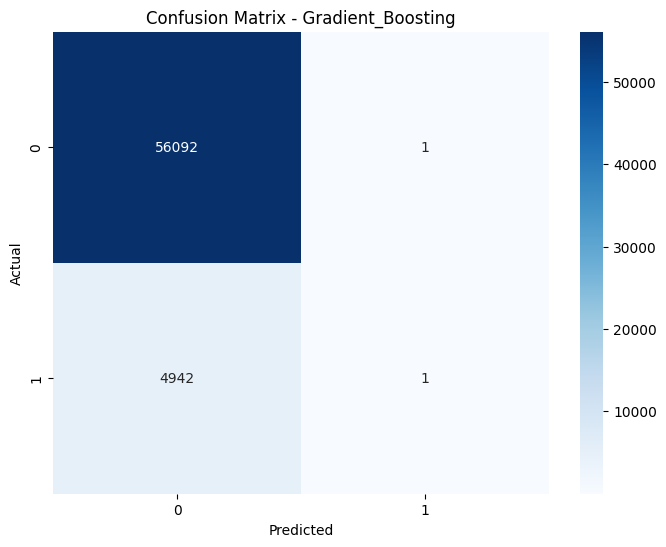

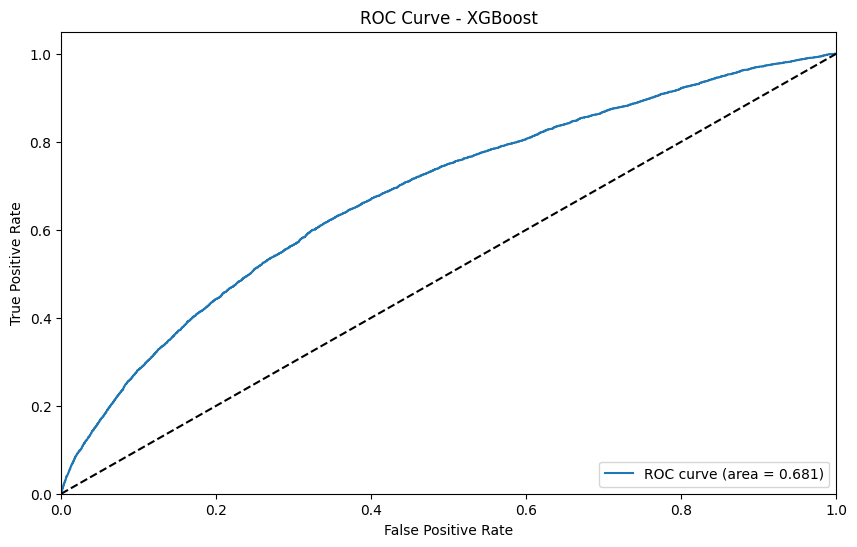

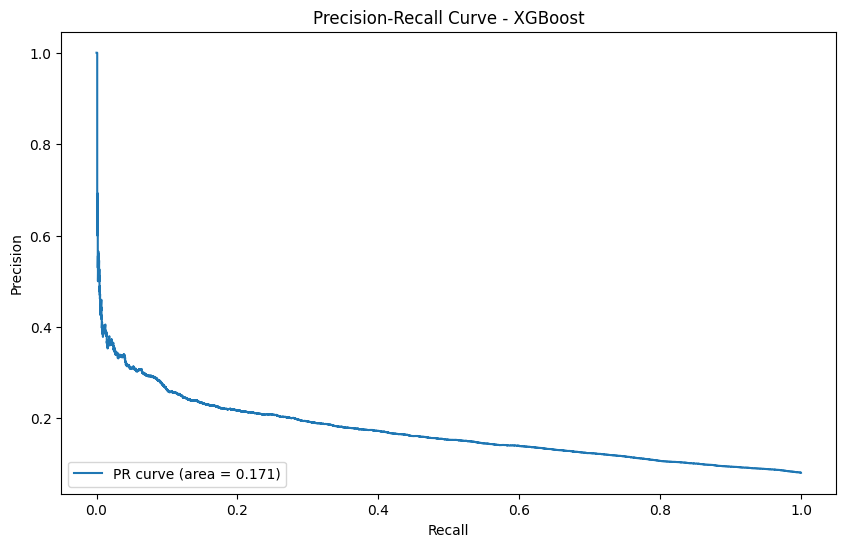

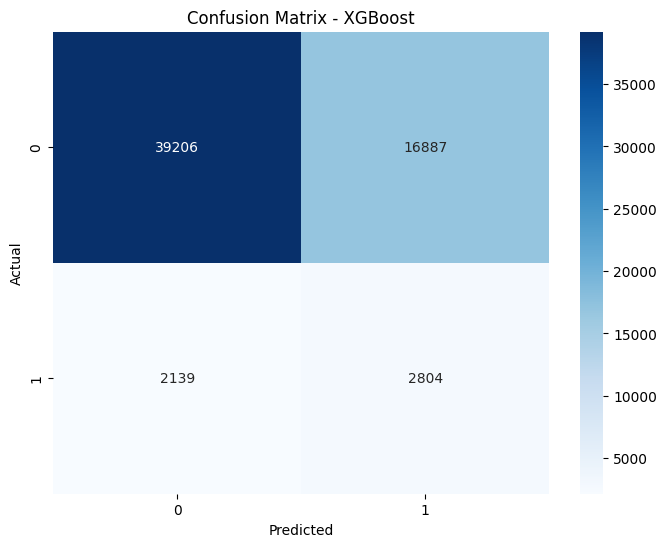

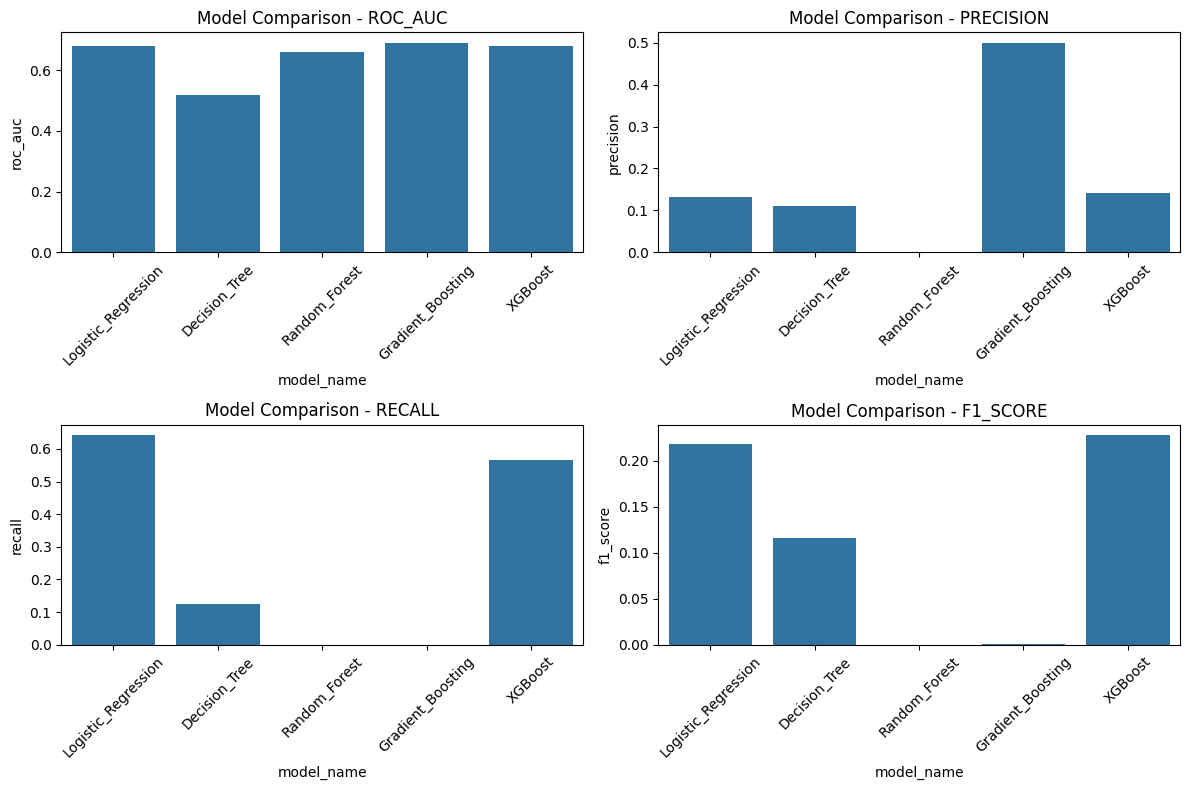

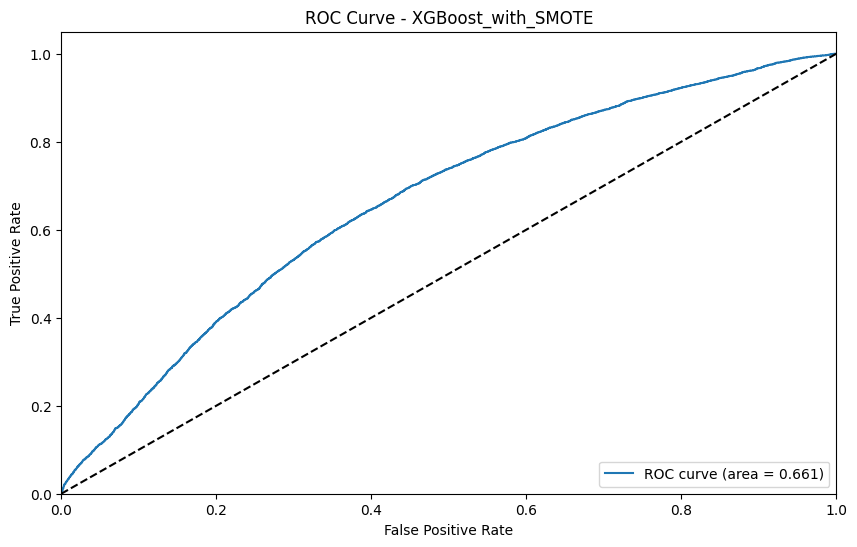

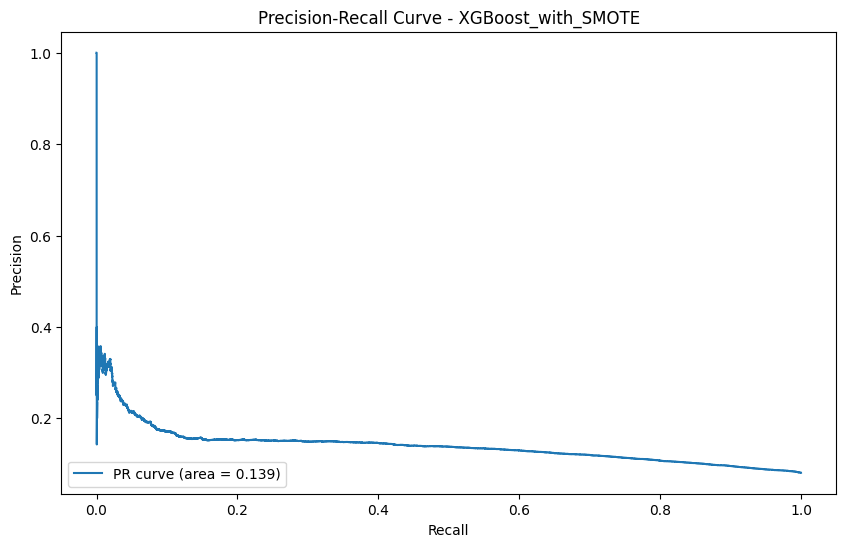

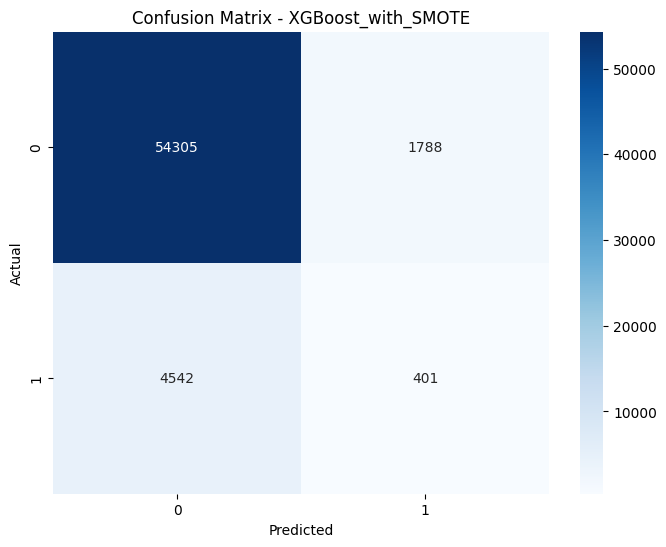

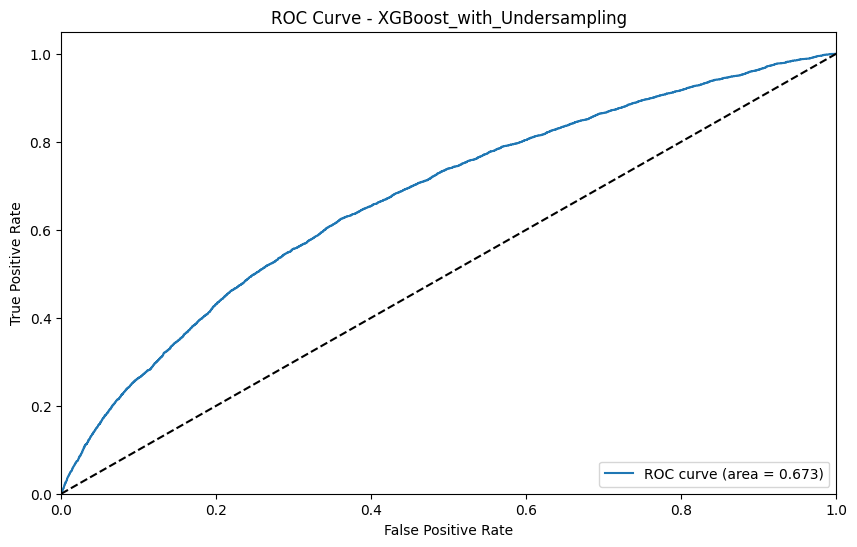

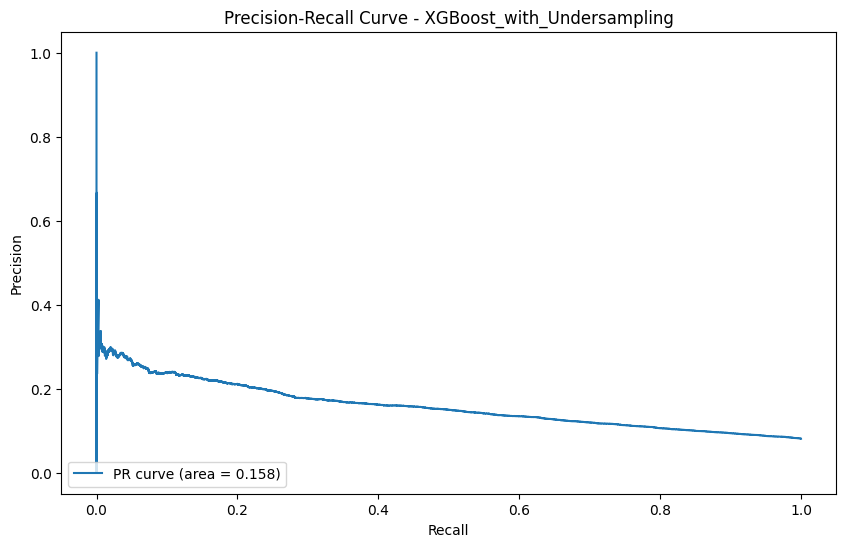

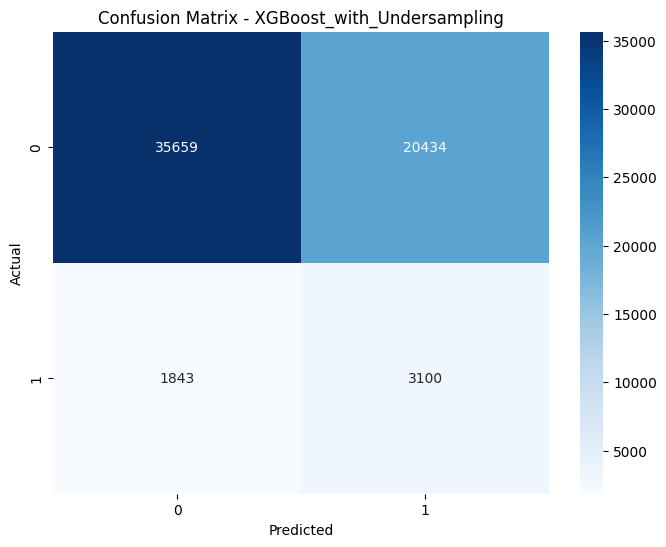

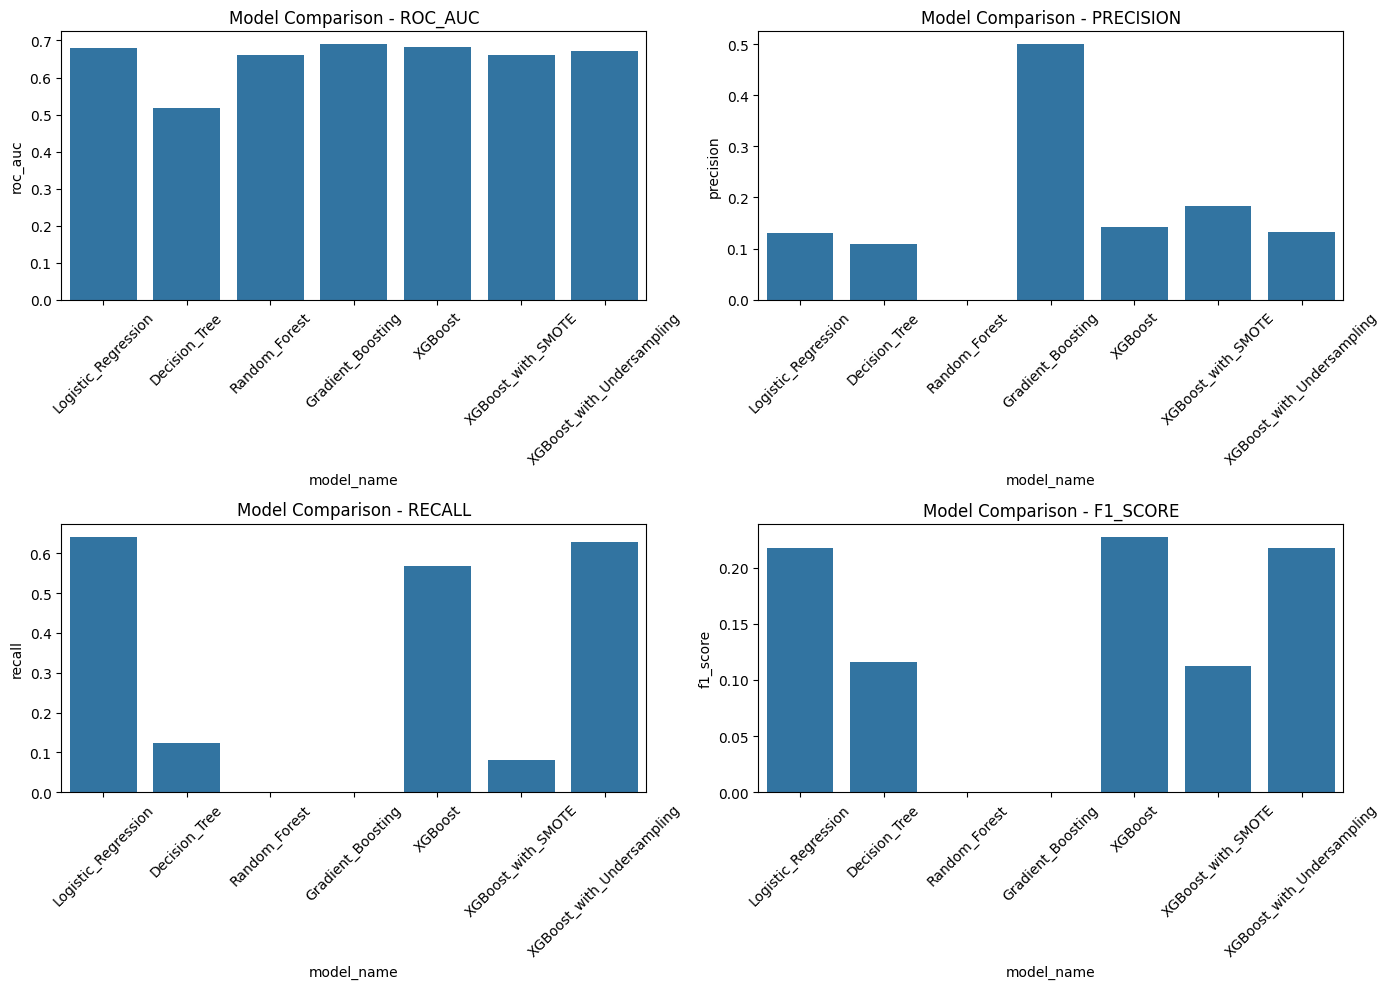

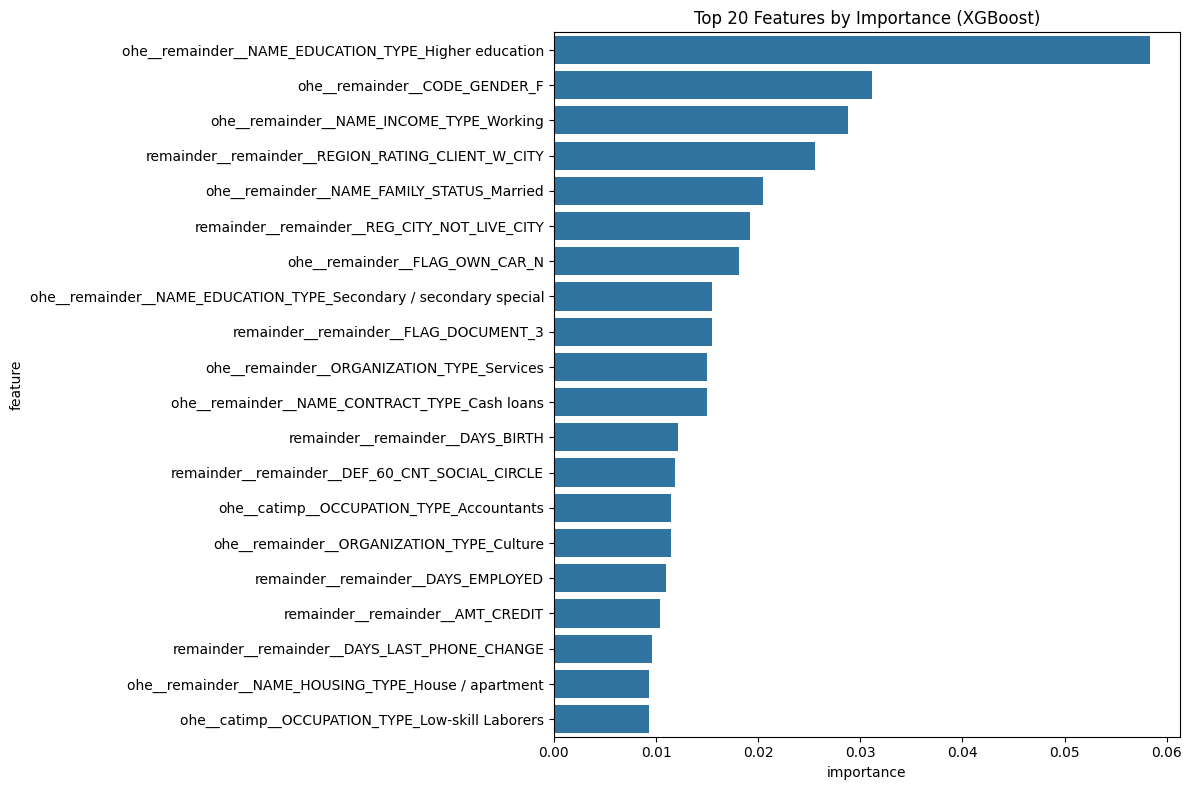

In [171]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Create classification report
    report = classification_report(y_test, y_pred)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    # plt.savefig(f'ml_results/{model_name}_roc_curve.png')
    
    
    # Plot Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    plt.figure(figsize=(10, 6))
    plt.plot(recall_curve, precision_curve, label=f'PR curve (area = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower left")
    # plt.savefig(f'ml_results/{model_name}_pr_curve.png')
    
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    # plt.savefig(f'ml_results/{model_name}_confusion_matrix.png')
    
    
    # Return metrics
    return {
        'model_name': model_name,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': report
    }

# Define models to evaluate
print("\nDefining models to evaluate...")
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=11.39, random_state=42)  # Using the imbalance ratio
}

# Evaluate each model
print("\nEvaluating models...")
results = []
for name, model in models.items():
    print(f"Evaluating {name}...")
    result = evaluate_model(model, X_train, X_test, y_train, y_test, name.replace(' ', '_'))
    results.append(result)
    print(f"  ROC AUC: {result['roc_auc']:.4f}")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")
    print(f"  F1 Score: {result['f1_score']:.4f}")
    print(f"  Classification Report:\n{result['classification_report']}\n")

# Create results summary
results_df = pd.DataFrame(results)
results_df = results_df.drop('classification_report', axis=1)
# results_df.to_csv('ml_results/model_comparison.csv', index=False)

# Plot model comparison
plt.figure(figsize=(12, 8))
metrics = ['roc_auc', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='model_name', y=metric, data=results_df)
    plt.title(f'Model Comparison - {metric.upper()}')
    plt.xticks(rotation=45)
    plt.tight_layout()
# plt.savefig('ml_results/model_comparison.png')


# Try SMOTE for handling class imbalance
print("\nEvaluating models with SMOTE for handling class imbalance...")
# Define SMOTE pipeline
smote_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

# Evaluate SMOTE pipeline
smote_result = evaluate_model(smote_pipeline, X_train, X_test, y_train, y_test, 'XGBoost_with_SMOTE')
print(f"  ROC AUC: {smote_result['roc_auc']:.4f}")
print(f"  Precision: {smote_result['precision']:.4f}")
print(f"  Recall: {smote_result['recall']:.4f}")
print(f"  F1 Score: {smote_result['f1_score']:.4f}")
print(f"  Classification Report:\n{smote_result['classification_report']}\n")

# Try undersampling for handling class imbalance
print("\nEvaluating models with undersampling for handling class imbalance...")
# Define undersampling pipeline
under_pipeline = Pipeline([
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

# Evaluate undersampling pipeline
under_result = evaluate_model(under_pipeline, X_train, X_test, y_train, y_test, 'XGBoost_with_Undersampling')
print(f"  ROC AUC: {under_result['roc_auc']:.4f}")
print(f"  Precision: {under_result['precision']:.4f}")
print(f"  Recall: {under_result['recall']:.4f}")
print(f"  F1 Score: {under_result['f1_score']:.4f}")
print(f"  Classification Report:\n{under_result['classification_report']}\n")

# Add resampling results to comparison
results.append(smote_result)
results.append(under_result)
results_df = pd.DataFrame(results)
results_df = results_df.drop('classification_report', axis=1)
# results_df.to_csv('ml_results/model_comparison_with_resampling.csv', index=False)

# Plot final model comparison
plt.figure(figsize=(14, 10))
metrics = ['roc_auc', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='model_name', y=metric, data=results_df)
    plt.title(f'Model Comparison - {metric.upper()}')
    plt.xticks(rotation=45)
    plt.tight_layout()
# plt.savefig('ml_results/final_model_comparison.png')


# Feature importance for the best model (assuming XGBoost performs well)
print("\nCalculating feature importance for XGBoost model...")
xgb_model = XGBClassifier(scale_pos_weight=11.39, random_state=42)
xgb_model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
# feature_importance.to_csv('ml_results/xgboost_feature_importance.csv', index=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 20 Features by Importance (XGBoost)')
plt.tight_layout()
# plt.savefig('ml_results/xgboost_feature_importance.png')


print("\nMachine learning evaluation completed. Results saved to ml_results directory.")

# Summary of recommended approaches
print("\nRecommended Machine Learning Approaches for Loan Default Prediction:")
print("1. Gradient Boosting and XGBoost models typically perform well for this type of problem")
print("2. Class imbalance handling techniques like SMOTE or class weights are essential")
print("3. Feature selection based on importance can improve model performance")
print("4. Evaluation should focus on metrics like ROC AUC, Precision, Recall, and F1 Score")
print("5. Threshold tuning can help balance precision and recall based on business requirements")


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [ ]:
model.fit(X_train, y_train)

## Code that we didn't use but I want to keep

In [ ]:
# # Encode categorical variables
# print('Encoding categorical variables...')
# # Apply label encoding to categorical columns
# label_encoders = {}
# for col in categorical_cols:
#     le = LabelEncoder()
#     df_cleaned[col] = le.fit_transform(df_cleaned[col])
#     label_encoders[col] = le
    
# print(f'Encoded {len(categorical_cols)} categorical columns')


# # Impute missing values for categorical columns with most frequent value
# cat_imp = ColumnTransformer(transformers=[('catimp', SimpleImputer(strategy='mode', add_indicator=True), categorical_cols)], 
#                        remainder="passthrough").set_output(transform='pandas')
# # num_imputer = SimpleImputer(strategy='mean', add_indicator=True)
# df_cat_imputed = num_imp.fit_transform(df_num_imputed)

# Fuck all this trash
# # we need to impute first before one-hot encoding and feature scaling
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import SimpleImputer, IterativeImputer
# from sklearn.linear_model import BayesianRidge
# from sklearn.neighbors import KNeighborsRegressor

# # let's use Bayesian Ridge(default) to impute missing values for Numerical col, then we can go back and compare strategies

# # need to create a separate dataframe for the columns we want to impute
# num_missing_col = ['AMT_REQ_CREDIT_BUREAU_HOUR',
#  'AMT_REQ_CREDIT_BUREAU_DAY',
#  'AMT_REQ_CREDIT_BUREAU_WEEK',
#  'AMT_REQ_CREDIT_BUREAU_MON',
#  'AMT_REQ_CREDIT_BUREAU_QRT',
#  'AMT_REQ_CREDIT_BUREAU_YEAR']

# num_missing_df = X_train[num_missing_col]

# num_imputer = IterativeImputer(
#     estimator=BayesianRidge(),
#     # add_indicator=True,
#     random_state=42,
#     n_nearest_features=3,
#     sample_posterior=True
# )

# num_imputed_array = num_imputer.fit_transform(num_missing_df)
# num_imputed_df = pd.DataFrame(num_imputed_array, columns=num_missing_df.columns)